\*
*DCGAN공부를 위해 **논문 및 온라인의 다양한 자료와 오픈소스의 코드를 활용**하여 만든 자료.* 

- DCGAN : https://arxiv.org/pdf/1511.06434.pdf
- 소스 코드 : https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb

# Generating Handwritten Digits with DCGAN

- Deep Convolutional Generative Adversarial Network (DCGAN)
    - GAN (Generative Adversarial Networks) 
        - Fully-connected network (일반적으로 서로서로 다 연결되어있는 뉴럴네트워크)
        - GAN은 일반적인 뉴럴네트워크로 구현을 하였다.
        - original paper : https://arxiv.org/pdf/1406.2661.pdf
    - DCGAN (Deep Convolutional Generative Adversarial Networks)
        - Deep convolution network
        - DCGAN은 CNN으로 구현하였다.
    - DCGAN 장점 (https://artoria.us/19)
        1. Scene을 이해하고 기존 GAN보다 고해상도의 이미지 생성
        1. 기존 GAN에 비해 안정된 학습 가능
        1. DCGAN의 특정 컨벌루션 필터가 특정 물체를 학습한다는 것 확인
        1. G에서 memorization이 일어난 것이 아니라는 것을 확인
        1. **G의 입력으로 들어가는 벡터에 대한 산술 연산이 가능한 점을 가지고 sementic(의미론적인)하게 출력 결과를 조절 가능**
            - like) 'KING − MAN + WOMAN = Queen'  in word2vec
            - (http://jaejunyoo.blogspot.com/2017/02/deep-convolutional-gan-dcgan-1.html)
         
- cf) cnn에 대한 개념 설명 good : https://bcho.tistory.com/1149
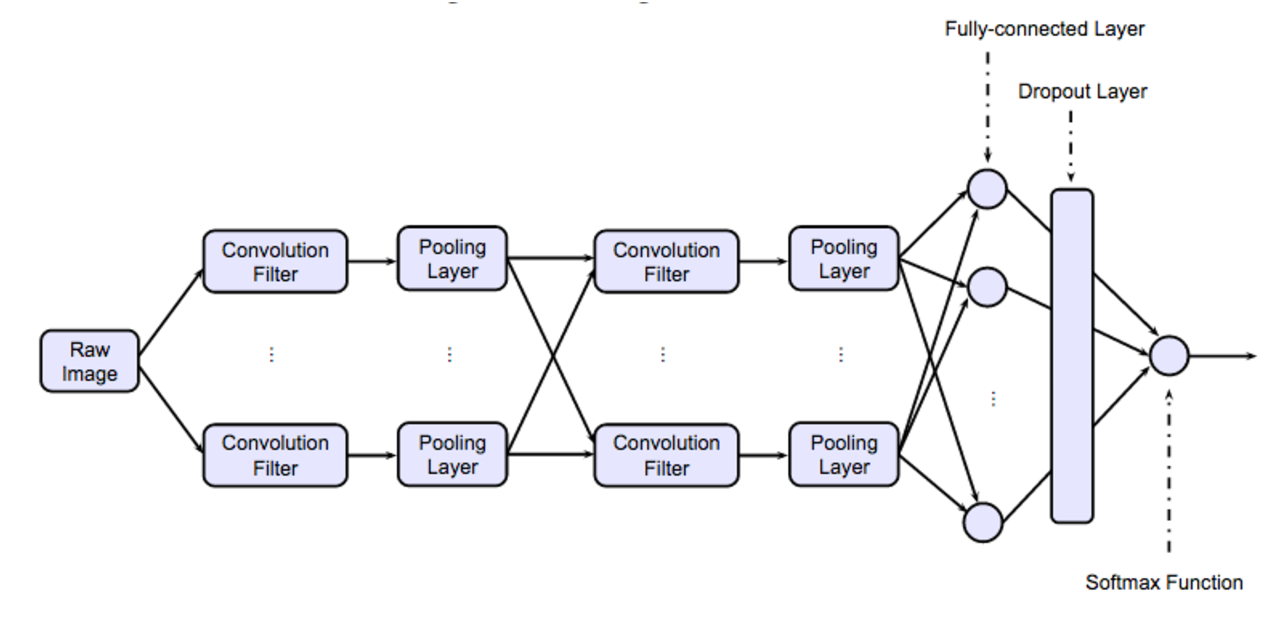
- cf) GAN의 개요도
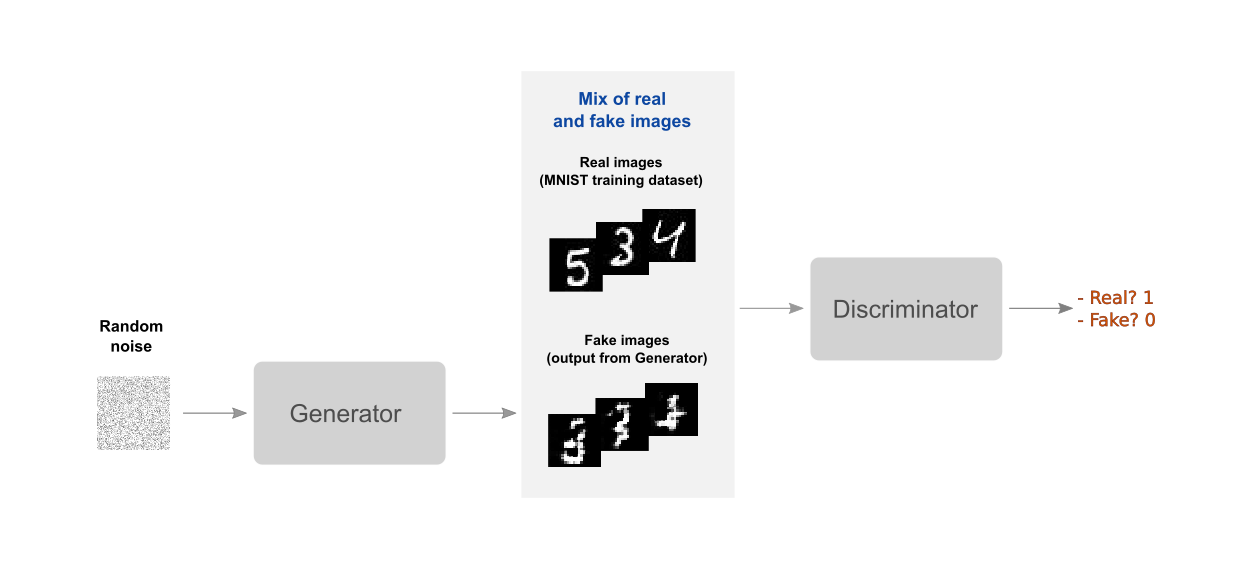

In [20]:
import tensorflow as tf
#tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

## Load dataset

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
#Use tf.data to create batches and shuffle the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the DCGAN models

- DCGAN 모델 구조 (논문 한글 번역 : https://artoria.us/19)
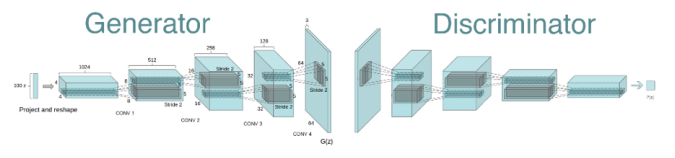
    1. D에서는 일반적인 CNN과 같이 Strided Convolution을 사용한다.
    1. G에서는 **upsampling**을 위해 Fractional Strided Convolution을 사용한다.(tensorflow의 tf.layers.conv2d_transpose)
    1. G와 D 모두에서 Batch Normalization을 적용하지만 불안정 및 발산 문제로 인해 **D 입력 레이어와 G 출력 레이어에서는 사용하지 않는다.**
    1. G에서는 ReLU를 사용하고 **마지막 레이어에서만 tanh**를 사용
    1. D에서는 모두 Leaky ReLU를 사용한다.
        - cf) 이는 실험적으로 알아낸 가장 최적의 구조이다.
        - Fractional Strided Convolution이란?
            - 기존 합성곱 연산처럼 필터를 거치며 다운샘플링되는것이 아니라 연산을 거치면 업샘플링되어 사이즈가 늘어나는 합성곱 연산이다. 텐서플로우에서는 tf.layers.conv2d_transpose라는 이름으로 구현되어있음.

- cf) Convolutional Layer : 컨볼루셔널 레이어는 앞에서 설명 했듯이 입력 데이타로 부터 특징을 추출하는 역할
- cf) Filter : 필터는 그 특징이 데이타에 있는지 없는지를 검출해주는 함수(행렬)
- cf) Stride : 
    - 이 필터를 어떻게 원본 이미지에 적용할까? 큰 사진 전체에 하나의 큰 필터 하나만을 적용할까?
    - 아래 그림을 보자, 5x5 원본 이미지가 있을때, 3x3인 필터를 좌측 상단에서 부터 왼쪽으로 한칸씩 그 다음 한줄을 내려서 또 왼쪽으로 한칸씩 적용해서 특징을 추출해낸다. 
    - 오른쪽 Convolved Feature 행렬이 바로 원본 이미지에 3x3 필터를 적용하여 얻어낸 결과 이다.
    - 이렇게 **필터를 적용 하는 간격** (여기서는 우측으로 한칸씩 그리고 아래로 한칸씩 적용하였다.) 값을 Stride라고 하고, 필터를 적용해서 얻어낸 결과를 Feature map 또는 activation map 이라고 한다. 
        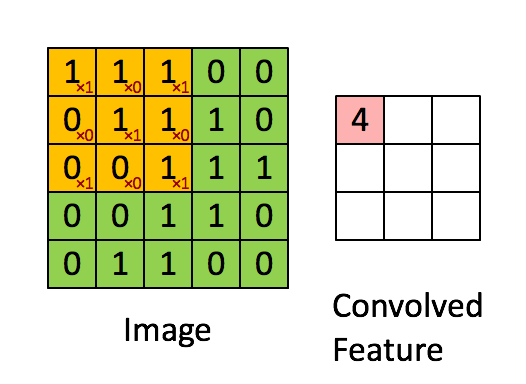
(출처: https://bcho.tistory.com/1149)

- cf) Batch Normalization의 장점은 다음과 같다.

    - https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/
    - https://arxiv.org/pdf/1502.03167.pdf
    - batch 단위로 샘플을 standardization해주는 역할!!
    - 기존 Deep Network에서는 learning rate를 너무 높게 잡을 경우 gradient가 explode/vanish 하거나, 나쁜 local minima에 빠지는 문제가 있었다. 이는 parameter들의 scale 때문인데, Batch Normalization을 사용할 경우 propagation 할 때 parameter의 scale에 영향을 받지 않게 된다. 따라서, learning rate를 크게 잡을 수 있게 되고 이는 빠른 학습을 가능케 한다.
    - Batch Normalization의 경우 자체적인 regularization 효과가 있다. 이는 기존에 사용하던 weight regularization term 등을 제외할 수 있게 하며, 나아가 Dropout을 제외할 수 있게 한다 (Dropout의 효과와 Batch Normalization의 효과가 같기 때문.) . Dropout의 경우 효과는 좋지만 학습 속도가 다소 느려진다는 단점이 있는데, 이를 제거함으로서 학습 속도도 향상된다.                

- cf) padding = valid or same
    - https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
    - 원본 데이터가 필터를 거친 후 작아졌을 때 여백을 0으로 채울지(same) 말지(valid).
    - 패딩은 결과 값을 작아지는 것을 막아서 특징이 유실되는 것을 막는 것 뿐 아니라, 오버피팅도 방지하게 되는데, 원본 데이타에 0 값을 넣어서 원래의 특징을 희석 시켜 버리고, 이것을 기반으로 머신러닝 모델이 트레이닝 값에만 정확하게 맞아 들어가는 오버피팅 현상을 방지한다.
(출처: https://bcho.tistory.com/1149)
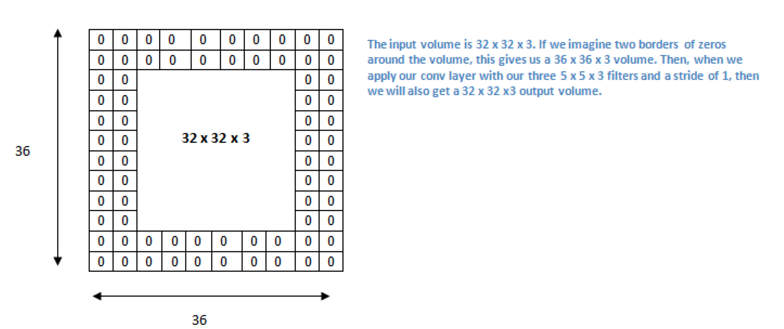 

- cf) tf.keras.layers.Dense의 역할?
    - densely-connected layer
    - 이는 아래 사진처럼 흔히 보이는 '완전연결계층'을 만들어줍니다.

출처: https://neurowhai.tistory.com/112 [NeuroWhAI의 잡블로그]

**upsampling에서 padding의 의미?**
     - cf) CNN에서 convolution layer는 convolution을 통해서 feature map의 크기를 줄인다. 하지만 Deconvolution(=Fractional Strided Convolution)은 이와 반대로 feature map의 크기를 증가시키는 방식으로 동작한다. 

- Deconvolution은 아래와 같은 방식으로 동작한다.
    1. 각각의 픽셀 주위에 zero-padding을 추가한다. 
    1. 이렇게 padding이된 것에 convolution 연산을 한다.

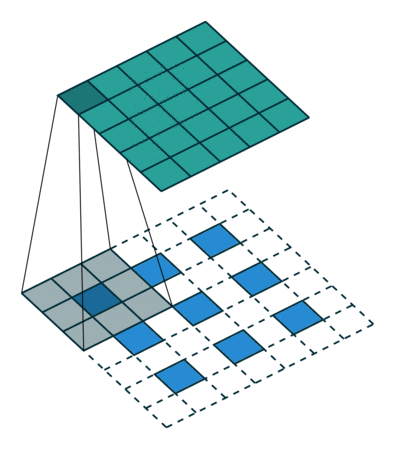

1. [위 그림] 파란색 픽셀 = input / 초록색 픽셀  = output 
1. 이 파란색 픽셀 주위로 흰색 zero-padding을 수행하고, 회색 filter를 통해 convolution 연산을 수행하여 초록색 output을 만들어낸다.
1. Deconvolution은 **downsampling되어있는 cnn의 최종 결과물을 다시 반대로 upsampling하여 input과 같은 사이즈를 만들어내고 싶을 때 쓰인다.** 
1. 주로 semantic segmentation등에 활용할 수 있다.
(출처: https://3months.tistory.com/209)

- Generator Model
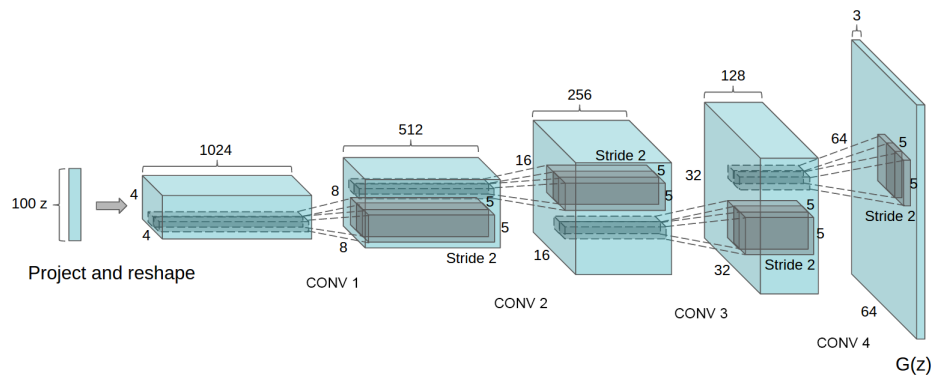
    - The generator is responsible for creating convincing images that are good enough to fool the discriminator. 
    - The network architecture for the generator consists of Conv2DTranspose (Upsampling) layers. 
    - We start with **a fully connected layer and upsample the image two times** in order to reach the desired image size of 28x28x1.
    - We **increase the width and height**, and **reduce the depth** as we move through the layers in the network. 
    - We use **Leaky ReLU activation (why?)** for each layer except for the last one where we use a tanh activation.
    - 즉, G는 이미지를 생성해야하기때문에 upsampling을 하는 것이다.


In [30]:
'''
1. G에서는 upsampling을 위해 Fractional Strided Convolution을 사용한다.(tensorflow의 tf.layers.conv2d_transpose)
2. G에서 Batch Normalization을 적용하지만 불안정 및 발산 문제로 인해 G 출력 레이어에서는 사용하지 않는다.
3. G에서는 ReLU를 사용하고 마지막 레이어에서만 tanh를 사용한다.
'''
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))  #dense가 뭐하는거지?
    model.add(tf.keras.layers.BatchNormalization()) # like Dropout
    model.add(tf.keras.layers.ReLU()) # LeakyReLU -> ReLU로 바꿈
      
    model.add(tf.keras.layers.Reshape((7, 7, 256))) #reshape 왜 해주지??
    assert model.output_shape == (None, 7, 7, 256) # model.output_shape == (None, 7, 7, 256) 가 True 인지 아닌지 확인. 틀리면 에러메세지 송출 
                                # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #FSC for upsampling
    # upsampling에서 padding의 의미?
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU()) # LeakyReLU -> ReLU로 바꿈

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU()) # LeakyReLU -> ReLU로 바꿈

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))#마지막은 tanh
    assert model.output_shape == (None, 28, 28, 1) 
  
    return model



In [6]:
'''
cf) the role of the command 'assert'
'''
i = 1
assert i!=0 # True : So nothing happens
assert i == 0 # False : pop up the error message. And stop the proccess 
1+1

AssertionError: 

- Discriminator model
    - The discriminator is responsible for distinguishing fake images from real images. 
    - It's similar to a regular CNN-based image classifier.
    - 즉, D는 이미지를 잘 구분하는 것이 목표이니 기존 CNN을 사용하면 된다.

In [31]:
'''
1. D에서는 일반적인 CNN과 같이 Strided Convolution(=down sampling)을 사용한다.
2. D에서 Batch Normalization을 적용하지만 불안정 및 발산 문제로 인해 D 입력 레이어에서는 사용하지 않는다.
3. D에서는 모두 Leaky ReLU를 사용한다.
'''
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) # SC for down sampling
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())  # Flatten()은 이미지를 일차원으로 바꿔줌
    model.add(tf.keras.layers.Dense(1))   #??
     
    return model


In [32]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss functions and the optimizer


## Generator loss
The generator loss is a sigmoid cross entropy loss of the generated images and an array of ones, 
since the generator is trying to generate fake images that resemble the real images.

- cross entropy : Maximizing Likelihood is Minimizing Cross-Entropy
    - 두 확률분포 p와 q 사이의 차이를 계산하는 데에는 크로스 엔트로피(cross entropy)라는 함수가 사용
    - corss_entropy = $- \sum p(x) \ln q(x)$
    - 여기에서 $p$를 우리가 가진 데이터의 분포 $P(Y|X)$, $q$를 모델이 예측한 결과의 분포 $P(\hat{Y}|X;θ)$로 두겠습니다. 이렇게 되면 크로스 엔트로피는 파라메터 $\theta$ 하에서의 음의 로그 우도(likelihood)의 기대값이라고 해석할 수 있습니다. 따라서 $−\sum x P(y|x) \ln P(y|x;\theta)$를 최소화하는 $\theta$가 바로 우리가 찾고 싶은 모델이 됩니다.
    - 출처 : https://ratsgo.github.io/deep%20learning/2017/09/24/loss/
- Categorical Cross-Entropy loss
    - Also called Softmax Loss. 
    - It is a Softmax activation plus a Cross-Entropy loss. 
    - If we use this loss, we will train a CNN to output a probability over the **C**  classes for each image. 
    - It is used for multi-class classification.  
    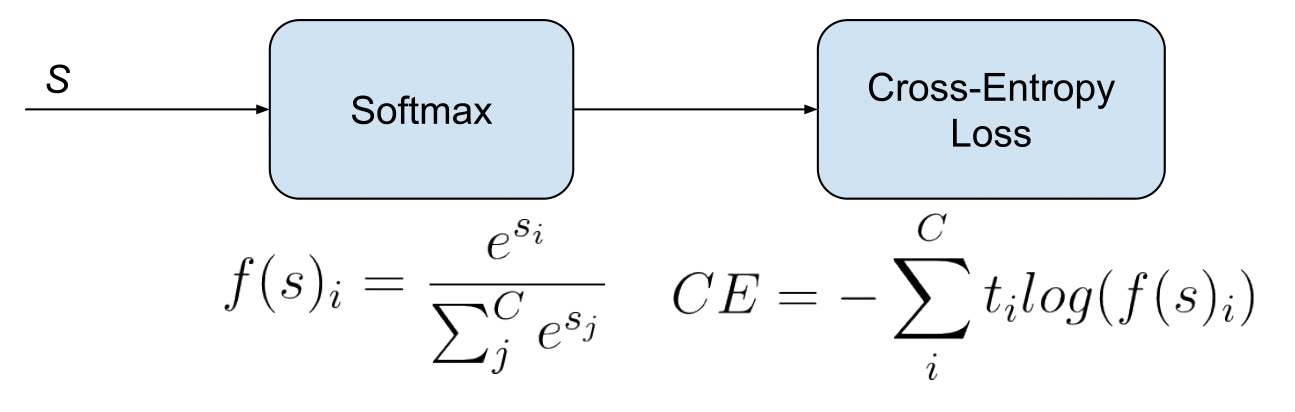
    - 출처 : https://gombru.github.io/2018/05/23/cross_entropy_loss/
- Binary Cross-Entropy Loss
    - Also called Sigmoid Cross-Entropy loss. 
    - It is a Sigmoid activation plus a Cross-Entropy loss. 
    - Unlike 'Softmax loss' it is independent for each vector component (class), meaning that the loss computed for every CNN output vector component is not affected by other component values. 
    - That’s why it is used for 'multi-label' classification, were the insight of an element belonging to a certain class should not influence the decision for another class.(??) 
    - It’s called Binary Cross-Entropy Loss because it sets up a binary classification problem between $C'=2$ classes for every class in $C'$ as explained above. 
    - So when using this Loss, the formulation of Cross Entroypy Loss for binary problems is often used:    
    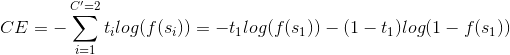
    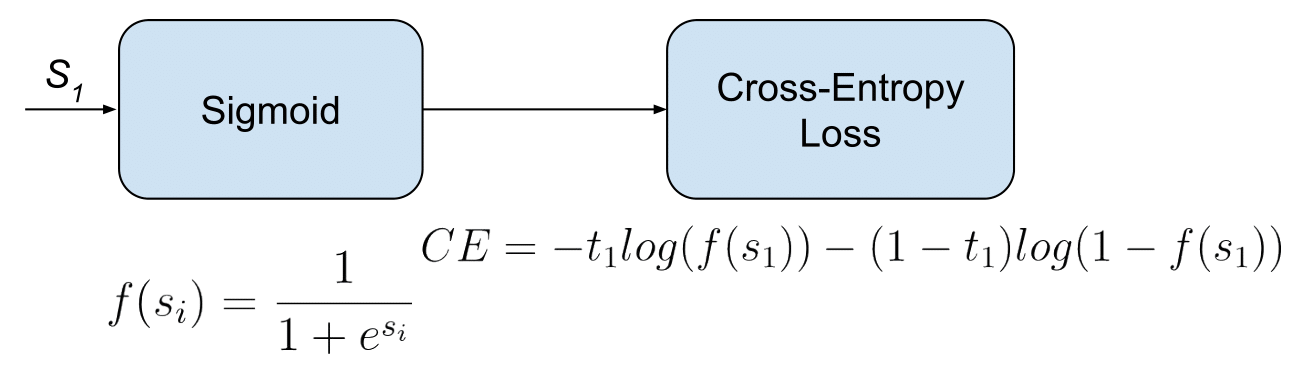


**cf) "GAN" loss function for D and G 수학 정의와 코드 구현**
- The loss function for Discriminator is given by

    - $\nabla_{\theta_d} \frac{1}{m}\sum^m_{i=1} \left( \ln D(x^{(i)}) + \ln(1-D(G(z^{(i)}))) \right)$

- The loss function for Generator is given by

    - $\nabla_{\theta_d} \frac{1}{m}\sum^m_{i=1} \ln(1-D(G(z^{(i)}))) $

- code : 

In [14]:
'''
G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)
D_loss = tf.reduce_mean(-tf.log(D_real)-tf.log(1-D_fake))
G_loss = tf.reduce_mean(-tf.log(D_fake))
# where D_real, D_fake and D_sample are the last layers of your network. 

#Then you can implement the training process by the standard way:

D_solver = (tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0.5)
            .minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0.5)
            .minimize(G_loss, var_list=theta_G))
'''
print('> 출처 : https://stackoverflow.com/questions/43622771/tensorflow-mnist-dcgan-how-to-set-up-the-loss-function')


> 출처 : https://stackoverflow.com/questions/43622771/tensorflow-mnist-dcgan-how-to-set-up-the-loss-function


- cf) Reduce Mean
    - 행렬에서 여러 값이 있을때 줄여 주는 역할, axis(=축)에 따라서 평균을 내어줌
    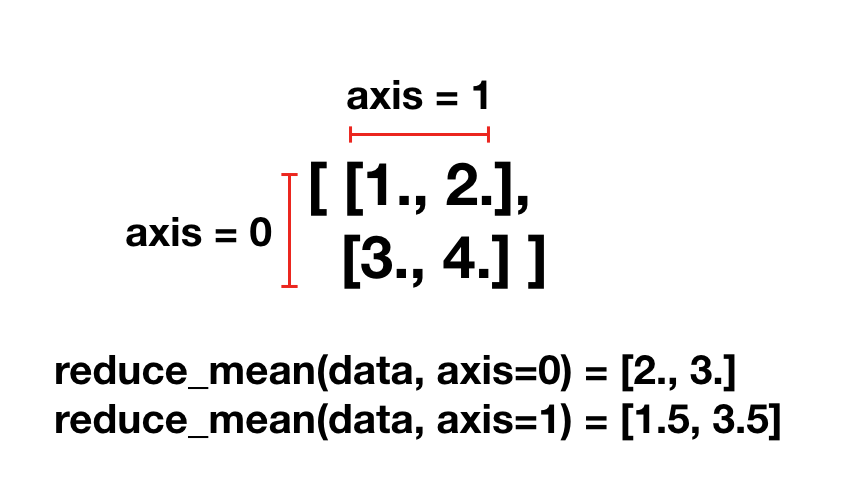
    
    - reduce_mean(data) : 행렬 data의 모든 성분을 다 더하고 성분 갯수로 나눠준다.
    - 출처 : https://jungwoon.github.io/tensorflow/toe/2017/12/19/MT-04-Tensor-Manipulation/

- 위의 공식대로 loss 함수를 짜보면 아래와 같다.
    - sigmoid 함수를 어디에 어떻게 넣어야할지 모르겠음.

In [16]:
# def generator_loss(generated_output):
#     D_fake = discriminator(generated_output)
#     G_loss = tf.reduce_mean(-tf.log(D_fake))
#     return G_loss

# def discriminator_loss(real_output, generated_output):
#     D_real = discriminator(real_output)
#     D_fake = discriminator(generated_output)
#     D_loss = tf.reduce_mean(-tf.log(D_real)-tf.log(1-D_fake))
#     return D_loss

In [90]:
#  Maximizing Likelihood is Minimizing Cross-Entropy
def generator_loss(generated_output):
    return tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output)
# tf.ones_like(generated_output) : generated_output 모양으로 다 1로 만든다.

## Discriminator loss
- The discriminator loss function takes two inputs: **real images, and generated images**. Here is how to calculate the discriminator loss:

    1. Calculate real_loss which is a sigmoid cross entropy loss of the real images and an array of ones (since these are the real images).
    1. Calculate generated_loss which is a sigmoid cross entropy loss of the generated images and an array of zeros (since these are the fake images).
    1. Calculate the total_loss as the sum of real_loss and generated_loss.

In [91]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.binary_crossentropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.binary_crossentropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss



# Optimizer
- The discriminator and the generator optimizers are different since we will train two networks separately.
- Optimizer는 일반적으로 많이 쓰는 Adam을 쓴다

In [92]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)


In [93]:
# Checkpoints (Object-based saving)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [94]:
checkpoint

- cf)  Checkpoint in tf
    - tensorflow 로 학습시킨 딥러닝 모델을 저장하는 방법중 하나로 Checkpoint 을 이용하는 방법이 있다.
    - Checkpoint 은 학습된 모델의 Variable 값을 저장하는 파일이다.
    - Checkpoint 파일을 저장하고 불러옴으로써 학습된 모델을 재사용하고, 지난 학습을 이어서 더 하고 하는 작업들이 가능해진다.

# Set up GANs for Training
Now it's time to put together the generator and discriminator to set up the Generative Adversarial Networks, as you see in the diagam at the beginning of the tutorial.

## Define training parameters
- We'll re-use this random vector used to **seed the generator**.
    - It will be easier to see the improvement over time.

**cf) Eager execution**
    - Eager Execution에서 텐서는 데이터를 직접 포인팅합니다. 그래서 tf.Session을 시작하지 않고 직접 값을 얻을 수 있습니다. 명령어 : tf.executing_eagerly()

In [ ]:
tf.executing_eagerly()

In [88]:
'''
cf) tf2.0에서 텐서 연산 예시
'''
test = [[2.,1.,4.]]
test2 = [[2.],[1.],[4.]]
sol = [[1.,1.,1.]]
m = tf.matmul(test, test2)
print(m)
tf.losses.binary_crossentropy(sol,test)

tf.Tensor([[21.]], shape=(1, 1), dtype=float32)


<tf.Tensor: id=672, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [95]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

----

## Define training method

We start by iterating over the dataset. The generator is given a random vector as an input which is processed to output an image looking like a handwritten digit. The discriminator is then shown the real MNIST images as well as the generated images.

Next, we calculate the generator and the discriminator loss. Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables.

- tf.GradientTape() ??

In [96]:
def train_step(images):
   # generating noise from a normal distribution
    noise = tf.random_normal([BATCH_SIZE, noise_dim]) #노이즈 생성
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) #G는 노이즈로부터 이미지 생성
      
        real_output = discriminator(images, training=True) #real image를 D에 넣어서 진짜/가짜 구분
        generated_output = discriminator(generated_images, training=True) #Fake image를 D에 넣어서 진짜/가짜 구분
         
        gen_loss = generator_loss(generated_output) #G의 loss 함수
        disc_loss = discriminator_loss(real_output, generated_output) #D의 loss함수
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))


----

In [109]:
'''
Eager execution can be slower than executing the equivalent graph 
as it can't benefit from whole-program optimizations on the graph, 
and also incurs overheads of interpreting Python code. 
By using tf.contrib.eager.defun to create graph functions, we get a ~20 secs/epoch performance boost 
(from ~50 secs/epoch down to ~30 secs/epoch). 
This way we get the best of both eager execution (easier for debugging) and graph mode (better performance).
'''
#객체화
train_step = tf.function(train_step) #?? 된건가??
#train_step = tf.contrib.eager.defun(train_step)
print('참고 : https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/function')

참고 : https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/function


In [99]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()
    
    for images in dataset:
        train_step(images)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs, random_vector_for_generation)

In [100]:
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the GANs
We will call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, you can see the generated digits look increasingly real. After 50 epochs, they look very much like the MNIST digits.

https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb

In [101]:
%%time
train(train_dataset, EPOCHS)
Restore the latest checkpoint


SyntaxError: invalid syntax (<unknown>, line 2)

In [102]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


# Generated images
After training, its time to generate some images! The last step is to plot the generated images and voila!

In [108]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no)) ## 파일이름의 역할??

In [106]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

# Generate a GIF of all the saved images
We will use imageio to create an animated gif using all the images saved during training.

In [107]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    

NameError: name 'filename' is not defined

In [ ]:
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

In [ ]:
#Display the animated gif with all the mages generated during the training of GANs.
display.Image(filename="dcgan.gif.png")